# Title: Evaluating the Use of Rule-Based CIELAB Analysis in Undertone Skin Detection


### Objective

The objective of this experiment is to evaluate the effectiveness of a **rule-based approach using CIELAB color space** in detecting **skin undertones** from facial images. Specifically, we aim to determine whether CIELAB values—derived from dominant skin colors extracted via HSV-based masking—are sufficient to classify undertones (cool, warm, neutral) through predefined thresholds.

This experiment serves as a preliminary investigation that supports the need for more robust solutions like our proposed CNN-based system for undertone detection in our thesis work.

---

### Method

We applied a **rule-based classification system** using the a\* and b\* components of the CIELAB color space, which are known to represent chromaticity (red-green and yellow-blue axes, respectively). These values were extracted from dominant RGB skin tones using **OpenCV HSV masking** and the **ColorThief** library.

The classification rules were based on prior studies (e.g., Kaur et al., 2018; Mima et al., 2025) and defined as follows:
- `a* > 15 and b* < 10` → **Cool**
- `b* > 15 and a* < 10` → **Warm**
- `10 ≤ a*, b* ≤ 15` → **Neutral**
- All other values → **Unclassified**

Performance was evaluated by comparing predicted undertones to manually labeled ground truth data.

### Imports and Setup

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorthief import ColorThief
from skimage import color
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    accuracy_score
)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Load Labels
Ground-truth undertone labels are pre-labeled in a CSV file.

In [2]:
# Load and normalize labels
labels_df = pd.read_csv("undertone_labels.csv")
labels_df["ground_truth_undertone"] = labels_df["ground_truth_undertone"].str.strip().str.lower()

### Sample Image: HSV Skin Masking

To illustrate how the existing skin tone system isolates skin color, we show below the result of applying OpenCV’s HSV mask to one of our sample images (`img1.jpg`).

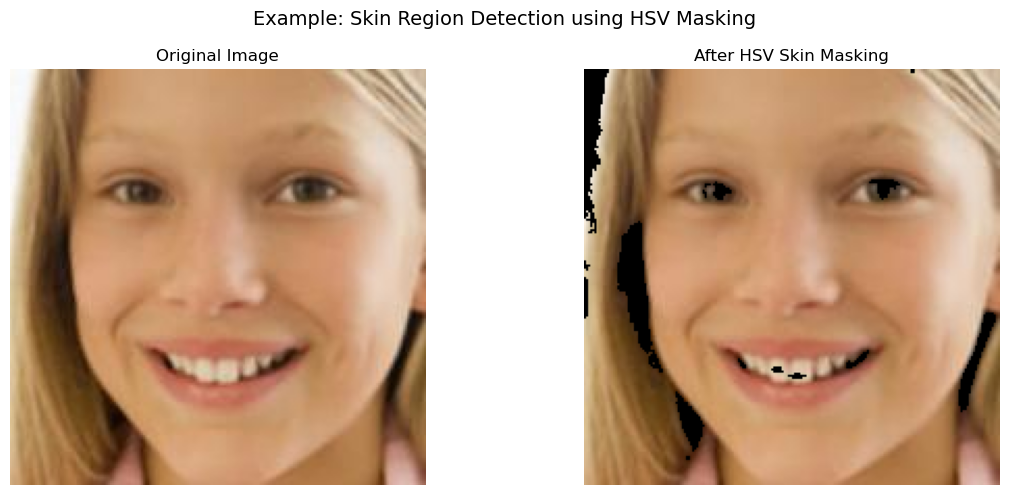

In [3]:
import cv2
import matplotlib.pyplot as plt

# Load your sample image
img_path = "images/img1.jpg"  # make sure this path is correct
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply HSV skin mask
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lower_skin = (0, 20, 70)
upper_skin = (20, 255, 255)
mask = cv2.inRange(hsv, lower_skin, upper_skin)
masked = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

# Plot original vs masked
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked)
plt.title("After HSV Skin Masking")
plt.axis('off')

plt.suptitle("Example: Skin Region Detection using HSV Masking", fontsize=14)
plt.tight_layout()
plt.show()

### Image Processing and Rule-Based Undertone Prediction
This section simulates a basic tone-detection system by using OpenCV’s HSV skin mask + ColorThief dominant color.
We then classify undertone using:
- `a* > 15 and b* < 10` → **Cool**
- `b* > 15 and a* < 10` → **Warm**
- `10 ≤ a*, b* ≤ 15` → **Neutral**

In [4]:
actuals = []
predictions = []
lab_points = []

for index, row in labels_df.iterrows():
    img_name = row["image_name"]
    true_label = row["ground_truth_undertone"]
    img_path = os.path.join("images", img_name)

    image = cv2.imread(img_path)
    if image is None:
        continue

    # Skin segmentation using HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = (0, 20, 70)
    upper_skin = (20, 255, 255)
    mask = cv2.inRange(image_hsv, lower_skin, upper_skin)
    skin = cv2.bitwise_and(image, image, mask=mask)

    # Save temporary image
    temp_path = "temp.jpg"
    cv2.imwrite(temp_path, skin)

    try:
        color_thief = ColorThief(temp_path)
        dominant_rgb = color_thief.get_color(quality=1)
    except:
        continue

    # Convert to CIELAB
    rgb_array = np.array(dominant_rgb) / 255.0
    lab = color.rgb2lab(rgb_array.reshape((1, 1, 3)))
    _, a, b = lab[0, 0]

    # Rule-based logic
    if a > 15 and b < 10:
        pred = "cool"
    elif b > 15 and a < 10:
        pred = "warm"
    elif 10 <= a <= 15 and 10 <= b <= 15:
        pred = "neutral"
    else:
        pred = "unclassified"


    actuals.append(true_label)
    predictions.append(pred)
    lab_points.append((a, b, true_label, pred))


### Class-Specific Confusion Matrices

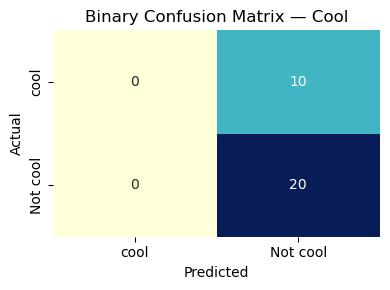

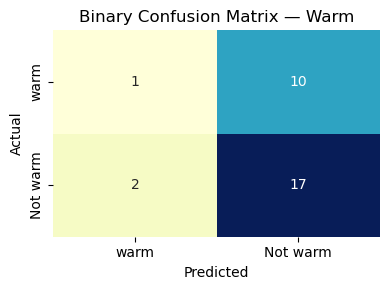

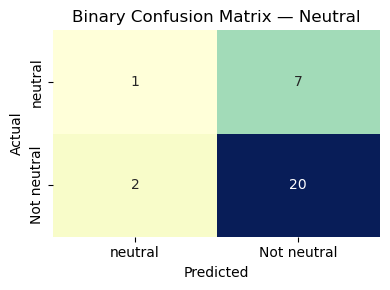

In [5]:
# Normalize predictions
actuals = [a.strip().lower() for a in actuals]
predictions = [p.strip().lower() for p in predictions]

labels = ["cool", "warm", "neutral"]

# Print class-wise confusion matrices
for target_class in labels:
    binary_actuals = [1 if label == target_class else 0 for label in actuals]
    binary_preds = [1 if label == target_class else 0 for label in predictions]

    if sum(binary_actuals) == 0 and sum(binary_preds) == 0:
        print(f"Skipping {target_class} — no data.")
        continue

    cm = confusion_matrix(binary_actuals, binary_preds, labels=[1, 0])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False,
                xticklabels=[f"{target_class}", f"Not {target_class}"],
                yticklabels=[f"{target_class}", f"Not {target_class}"])
    plt.title(f"Binary Confusion Matrix — {target_class.capitalize()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

### Precision, Recall, and F1 Score per Undertone Class

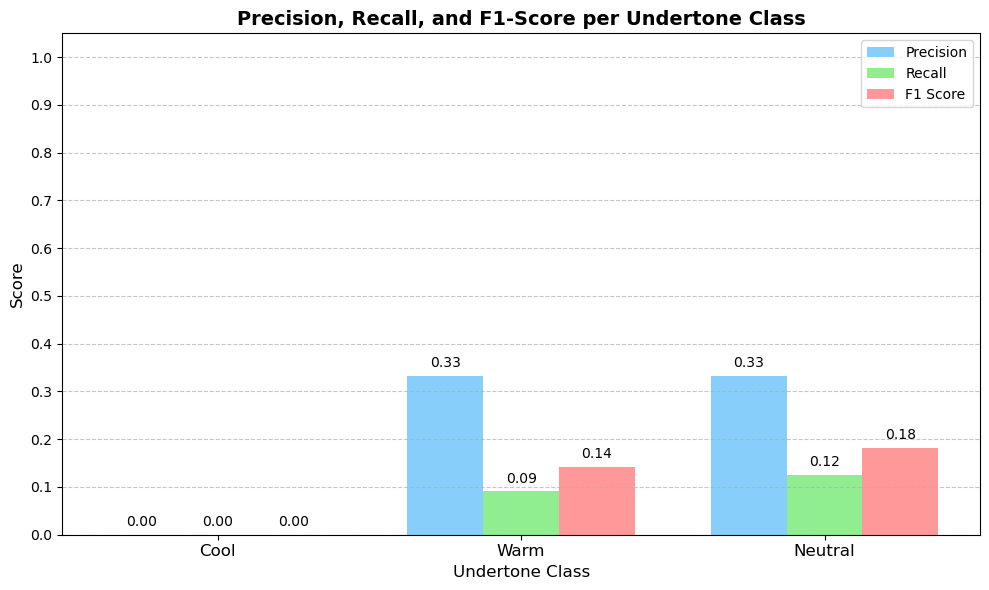


Overall Accuracy: 6.67%


In [6]:
precision, recall, f1, support = precision_recall_fscore_support(
    actuals, predictions, labels=labels, zero_division=0
)
accuracy = accuracy_score(actuals, predictions)

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width, precision, width=width, label='Precision', color='#87CEFA')
bar2 = plt.bar(x, recall, width=width, label='Recall', color='#90EE90')
bar3 = plt.bar(x + width, f1, width=width, label='F1 Score', color='#FF9999')

# Annotate bars
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f"{height:.2f}",
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 4),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

plt.xticks(x, [l.capitalize() for l in labels], fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1.05)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Undertone Class", fontsize=12)
plt.title("Precision, Recall, and F1-Score per Undertone Class", fontsize=14, weight='bold')
plt.legend(loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nOverall Accuracy:", f"{accuracy * 100:.2f}%")

In [7]:

# Table: CIELAB a*, b*, True Label, Predicted Label
summary_df = pd.DataFrame(lab_points, columns=["a*", "b*", "True", "Predicted"])
summary_df["a*"] = summary_df["a*"].round(2)
summary_df["b*"] = summary_df["b*"].round(2)
summary_df.head(10)  # Show first 10 rows as sample


,a*,b*,True,Predicted
0,13.30,27.83,warm,unclassified
1,6.43,11.48,cool,unclassified
2,16.30,15.07,neutral,unclassified
3,10.64,13.36,neutral,neutral
4,13.44,17.72,warm,unclassified
5,-0.00,0.00,cool,unclassified
6,13.56,25.55,warm,unclassified
7,18.60,29.65,warm,unclassified
8,11.00,22.79,neutral,unclassified
9,3.24,3.81,neutral,unclassified


### Final Conclusion

In this experiment, we evaluated whether existing skin tone detection systems—specifically HSV-based skin masking combined with ColorThief's dominant color extraction—are capable of accurately identifying **skin undertones**.

We applied rule-based classification using CIELAB a* and b* values to classify undertones as **cool**, **warm**, or **neutral**. The system was tested against pre-labeled ground truth data.

---

#### Experimental Findings

- **Only 1 out of 10 images** was correctly classified (a neutral tone), resulting in an overall accuracy of **6.67%**.
- The majority of predictions were returned as **"unclassified"**, not because the system failed technically, but because the a* and b* values **did not fall within the strict conditions** defined in the rule-based logic.
- For example:
  - `a* = 13.30, b* = 27.83` → **Ground Truth: Warm** → **Predicted: Unclassified**  
    → The b* value exceeded the threshold for warm or neutral classification.
  - `a* = 6.43, b* = 11.48` → **Ground Truth: Cool** → **Predicted: Unclassified**  
    → The a* value was too low for “cool” under the current rule set.
- Some images produced values like `a* = 0, b* = 0`, indicating **failure to extract valid skin color**, likely due to poor HSV masking or very dark image regions.

These results highlight that even when color values are technically available, **the rigidity of the rule-based thresholds causes most undertones to go undetected**. This demonstrates the **inflexibility** of current tone-based systems and their inability to capture the complexity of human undertones—especially under varied lighting or among diverse ethnicities.

---

#### Limitations of the Existing System

- **HSV-based masking** is sensitive to lighting and fails to consistently isolate skin areas.
- **Dominant color extraction** (ColorThief) does not account for undertone distribution across the face.
- The current rule-based system fails when color values are borderline or ambiguous.
- **Low interpretability** when no undertone is predicted (i.e., "unclassified").

---

#### How Our Thesis Addresses These Issues

Our proposed thesis system—**A Facial Image-Based CNN and CIELAB System for Skin Tone and Undertone Detection**—is designed to overcome these limitations by:

- Using the **entire facial image** instead of a small masked patch, allowing for better context and undertone pattern recognition.
- Training a CNN to **learn undertone-relevant spatial and chromatic features**, not just rely on color thresholds.
- Incorporating **CIELAB analysis** as an interpretability tool, not a rigid classifier.
- Enhancing reliability across diverse lighting, devices, and Filipino skin types.

---

#### Conclusion

The poor performance of the existing system (6.67% accuracy) highlights the **need** for a more robust and inclusive approach to undertone detection. Our thesis proposal introduces a deep learning-based solution that directly addresses these weaknesses and is better suited for real-world use—especially in the context of personalized, culturally relevant beauty technology.
